In [1]:
%matplotlib inline

from collections import deque,namedtuple
import random
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state','done'))
class VanillaMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size) 
    def add(self, *args):
        t = Transition(*args)
        self.memory.append(t)
    def sample(self, batch_size):
        ts = random.sample(self.memory, batch_size)
        states = np.vstack([t.state for t in ts])
        actions = np.vstack([t.action for t in ts])
        rewards = np.vstack([t.reward for t in ts])
        next_states = np.vstack([t.next_state for t in ts])
        dones = np.vstack([t.done for t in ts]).astype(np.uint8)
        return(states,actions,rewards,next_states,dones)
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return(len(self.memory))

In [2]:
mem = VanillaMemory(1000)
len(mem)

0

In [3]:
env = gym.make('MountainCar-v0')
state = env.reset()
score = 0
t=0
frames = []
while True:
    action = np.random.choice([0,1,2])
    next_state, reward, done, info = env.step(action)
    mem.add(state,action,reward,next_state,done)
    
    state = next_state
    t+=1
    score+=reward
    if done: break
print(f'Done in {t} timsteps with score {score}.')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Done in 200 timsteps with score -200.0.


In [4]:
mem.sample(3)

(array([[-0.49779804,  0.00551482],
        [-0.4311884 ,  0.00918203],
        [-0.62012039,  0.00481292]]), array([[2],
        [0],
        [0]]), array([[-1.],
        [-1.],
        [-1.]]), array([[-0.49147654,  0.00632151],
        [-0.4236906 ,  0.0074978 ],
        [-0.61559363,  0.00452676]]), array([[0],
        [0],
        [0]], dtype=uint8))

In [5]:
class CriticNetwork(models.Model):
    def __init__(self, action_size, nb_hidden):
        super(CriticNetwork,self).__init__()
        self.body = [layers.Dense(i, activation='relu') for i in nb_hidden]
        self.head = layers.Dense(action_size)
    def call(self,state):
        x = state
        for l in self.body: x = l(x) 
        return self.head(x)
m = CriticNetwork(env.action_space.n, [256])
m.trainable_weights

[]

In [6]:
#you need to build with input dimensions first to get weights
m.build(input_shape=(None,env.reset().shape[0]))
[i.shape for i in m.trainable_weights]

[TensorShape([2, 256]),
 TensorShape([256]),
 TensorShape([256, 3]),
 TensorShape([3])]

In [7]:
m(env.reset()[None,:])

<tf.Tensor: id=70, shape=(1, 3), dtype=float32, numpy=array([[0.00910168, 0.03327731, 0.06524313]], dtype=float32)>

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., nb_hidden = [256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1, tpe = 200):
        
        self.state_size = state_size
        self.action_size = action_size
        self.nb_hidden = nb_hidden
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.tpe = tpe
        self.clip = clip

        #vanilla
        self.network_local = CriticNetwork(self.action_size,self.nb_hidden)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = CriticNetwork(self.action_size,self.nb_hidden)
        self.network_target.build(input_shape=(None,self.state_size))
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps
        self.t_step = 0
    
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        eps = max(eps_start * (eps_decay ** i), eps_end)
        return(eps)
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        #update target network
        self.soft_update()
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                #vanilla
                for _ in range(self.update_times):
                    transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)
                    
    def act(self, state):
        eps = self.get_eps(int(self.t_step / self.tpe))
        action_values = self.network_local(state[None,:])
        #epsilon greedy
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    #we use tf.function decorator for training process to switch from eager to static graph
    @tf.function
    def learn(self, transitions):
        states, actions, rewards, next_states, dones = transitions
        
        #when in tf.functions everything is tensor but maybe not the type we want
        states = tf.cast(states,dtype=tf.float32)
        actions = tf.cast(actions,dtype=tf.int32)
        rewards = tf.cast(rewards,dtype=tf.float32)
        next_states = tf.cast(next_states,dtype=tf.float32)
        dones = tf.cast(dones,dtype=tf.float32)
        
        #get q_targets
        q_targets_next = tf.reduce_max(self.network_target(next_states),1)[:,tf.newaxis]
        q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get predictions of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            seq = tf.range(0, actions.shape[0])
            action_idxs = tf.transpose(tf.stack([seq, actions]))

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            q_expected = tf.gather_nd(preds, action_idxs)
            
            #calculate loss
            loss = tf.keras.losses.mse(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))
        return loss

    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)

In [9]:
env = gym.make('CartPole-v1')
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = env.action_space.n, replay_memory = mem) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [10]:
from datetime import datetime

scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=190

for i in tqdm_notebook(range(500)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    while True:
        t+=1
        #select action
        action = a.act(state)  

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motive your agent even more
        if done: 
            fake_reward = reward #+ (200-t)/10
        else:
            fake_reward = reward

        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
        
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Episdoe 99 Moving Average: 17.31313131313131
Episdoe 199 Moving Average: 12.7
Episdoe 299 Moving Average: 16.75
Episdoe 399 Moving Average: 133.6
Solved at Play 425: 0:01:42.265804 Moving average: 190.12


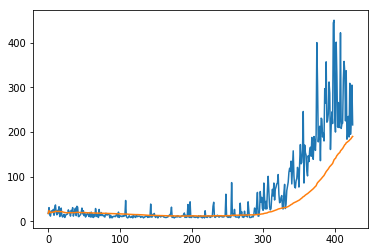

In [11]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

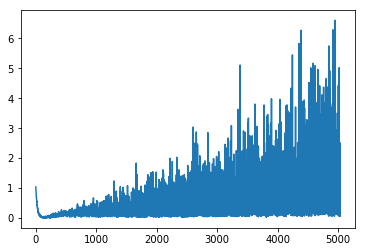

In [12]:
plt.plot(a.losses)